# Dataset from video

In [1]:
import os
import json
import pathlib
import shutil
from pytubefix import YouTube

import matplotlib.pyplot as plt
import cv2
import mlflow
from pprint import pprint

import torch
import numpy as np

import chess

# Pull video from YouTube

In [36]:
def pull_video(video_id, save_dir):
    out_fn = f"{save_dir}/{video_id}.mp4"
    if os.path.exists(out_fn):
        return

    yt = YouTube(
        f"https://www.youtube.com/watch?v={video_id}"
    )
    print(f"Downloading video: {yt.title}")

    stream = yt.streams.get_highest_resolution()
    stream.download()
    fn = stream.default_filename
    shutil.move(fn, out_fn)

current_dir = pathlib.Path.cwd()
base_dir = current_dir.parent
save_dir = base_dir / "data" / "videos"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
video_id = "KtTtQN8-96c"
pull_video(video_id, save_dir)

# Extract frame from video

- https://www.youtube.com/watch?v=KtTtQN8-96c

In [40]:
def get_frame(video_path, time_sec):
    vidcap = cv2.VideoCapture(video_path)
    frame_count = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, int(fps * time_sec))
    success, image = vidcap.read()
    vidcap.release()
    if success:
        return image
    else:
        return None

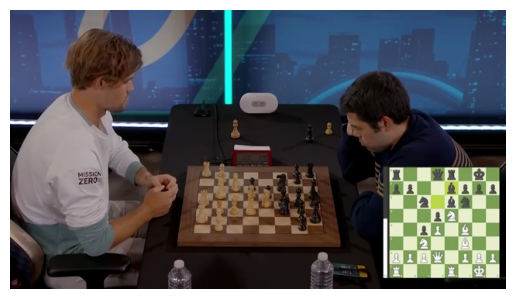

In [ ]:

current_dir = pathlib.Path.cwd()
base_dir = current_dir.parent
video_name = "KtTtQN8-96c"
video_path = base_dir / "data" / "videos" / f"{video_name}.mp4"

video_min = 4
video_seconds = 58
time_sec =  video_min * 60 + video_seconds
image = get_frame(video_path, time_sec)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Get gt and irl chessboard

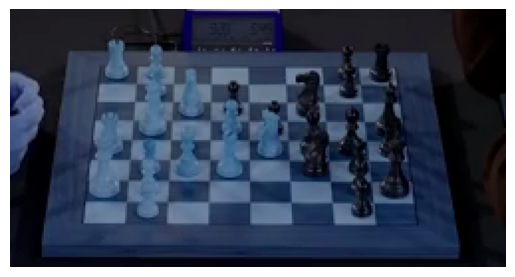

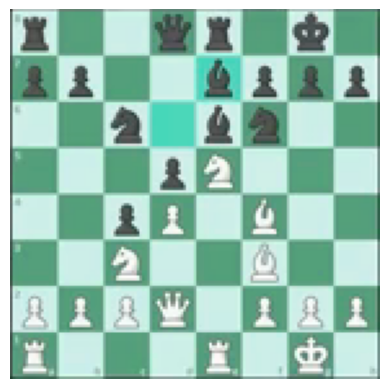

In [ ]:
def extract_gt_board(img, gt_board_loc, irl_board_loc):
    top, bottom, left, right = gt_board_loc
    gt_board = img[top:bottom, left:right, :].copy()
    irl_top, irl_bottom, irl_left, irl_right = irl_board_loc
    irl_board = img[irl_top:irl_bottom, irl_left:irl_right, :].copy()
    # if self.first_frame_img is None:
    #     img[top:bottom, left:right, :] = 0
    #     return img, gt_board, irl_board
    #img[top:bottom, left:right, :] = self.first_frame_img[top:bottom, left:right, :]
    return gt_board, irl_board


In [ ]:
gt_board_loc = [203, 346, 489, 632] # [y1, y2, x1, x2]
irl_board_loc = [180, 310,  200, 450] # [y1, y2, x1, x2]

gt_board, irl_board = extract_gt_board(image, gt_board_loc, irl_board_loc) 

plt.imshow(irl_board)
plt.axis("off")
plt.show()

plt.imshow(gt_board)
plt.axis("off")
plt.show()

# Test model

## Load model

Single chessboard no blur

In [5]:
# Load model from mlflow
mlruns_dir = str(pathlib.Path.cwd().parent / "data" / "mlruns")
mlflow.set_tracking_uri("file://" + mlruns_dir)
run_id = "4deab14be91f40289414ecd5304923e6"
model = mlflow.pytorch.load_model("runs:/" + run_id + "/best_model")

/Users/alexquiroga/anaconda3/envs/computer_vision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Multiple chessboards and blur

In [6]:
# Load model from mlflow
mlruns_dir = str(pathlib.Path.cwd().parent / "data" / "mlruns")
mlflow.set_tracking_uri("file://" + mlruns_dir)
run_id = "36aa38a2ba8a41a5841265e48c030eea"
model = mlflow.pytorch.load_model("runs:/" + run_id + "/best_model")

## Dataset selection

In [7]:
#DATASET_FOLDER_NAME = "chessboard_2d_rendered"
DATASET_FOLDER_NAME = "chessboard_2d_rendered_aug"

Load map between labels and IDs

In [ ]:
def load_id2label_map(dataset_dir):
    labels_mapping_path = dataset_dir / "labels_mapping.json"

    with open(labels_mapping_path, 'r') as f:
        labels_map = json.load(f)

    id2label = labels_map["id2class"]

    # Convert keys to int
    id2label = {int(k): v for k, v in id2label.items()}

    return id2label

dataset_dir = base_dir / "data" / DATASET_FOLDER_NAME
id2label_map = load_id2label_map(dataset_dir)

pprint(id2label_map)

{0: '0',
 1: 'B',
 2: 'K',
 3: 'N',
 4: 'P',
 5: 'Q',
 6: 'R',
 7: 'b',
 8: 'k',
 9: 'n',
 10: 'p',
 11: 'q',
 12: 'r'}


In [ ]:
# current_dir = pathlib.Path.cwd()
# base_dir = current_dir.parent
# dataset_dir = base_dir / "data" / DATASET_FOLDER_NAME
# labels_mapping_path = dataset_dir / "labels_mapping.json"

# with open(labels_mapping_path, 'r') as f:
#     labels_map = json.load(f)

# id2label = labels_map["id2class"]

# # Convert keys to int
# id2label = {int(k): v for k, v in id2label.items()}

# pprint(id2label)

{0: '0',
 1: 'B',
 2: 'K',
 3: 'N',
 4: 'P',
 5: 'Q',
 6: 'R',
 7: 'b',
 8: 'k',
 9: 'n',
 10: 'p',
 11: 'q',
 12: 'r'}


## Test with dataset image

Don't run this to predict from video gt board

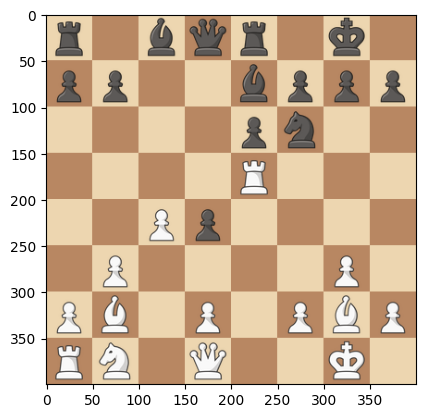

In [9]:
#img_path = base_dir / f"data/{DATASET_FOLDER_NAME}/test/images/Hikaru_HansOnTwitch_020.png"

# Choose a random image from test dir
import random
test_images = list((base_dir / f"data/{DATASET_FOLDER_NAME}/test/images").glob("*.png"))
img_path = random.choice(test_images)

gt_board = cv2.imread(img_path)

# Crop the board padding
BOARD_PADDING = 0
h, w = gt_board.shape[:2]
start_h = int(h * BOARD_PADDING // 100)
start_w = int(w * BOARD_PADDING // 100)
gt_board = gt_board[start_h:h-start_h, start_w:w-start_w]

plt.imshow(cv2.cvtColor(gt_board, cv2.COLOR_BGR2RGB))

## Split gt board and predict

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


def predict_gt_board(gt_board_img, model, id2label, device):

    SQUARE_SIZE = 60

    pred_board_arr = np.empty((8, 8), dtype=object)

    for row in range(8):
        for col in range(8):
            
            # Crop the specific square
            gt_board_img = cv2.resize(gt_board_img, (8 * SQUARE_SIZE, 8 * SQUARE_SIZE))
            square_img = gt_board_img[row*SQUARE_SIZE:(row+1)*SQUARE_SIZE, col*SQUARE_SIZE:(col+1)*SQUARE_SIZE]

            # Predict the square
            square_img = cv2.cvtColor(square_img, cv2.COLOR_BGR2RGB)
            square_img = square_img / 255.0
            square_img = square_img.transpose((2, 0, 1)) # (3, 60, 60)
            square_img = torch.tensor(square_img, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                preds = model(square_img)
                preds = preds.argmax(dim=1).cpu().numpy()

            # Map the predicted class to the corresponding label
            predicted_label = id2label.get(preds[0], "Unknown")
            #print(f"Predicted label for square ({row}, {col}): {predicted_label}")

            # Add to predictions array
            pred_board_arr[row, col] = predicted_label

    return pred_board_arr


pred_board_arr = predict_gt_board(gt_board, model, id2label_map, device)

print(pred_board_arr)

Using device: mps
[['r' '0' 'b' 'q' 'r' '0' 'k' '0']
 ['p' 'p' '0' '0' 'b' 'p' 'p' 'p']
 ['0' '0' '0' '0' 'p' 'n' '0' '0']
 ['0' '0' '0' '0' 'R' '0' '0' '0']
 ['0' '0' 'P' 'p' '0' '0' '0' '0']
 ['0' 'P' '0' '0' '0' '0' 'P' '0']
 ['P' 'B' '0' 'P' '0' 'P' 'B' 'P']
 ['R' 'N' '0' 'Q' '0' '0' 'K' '0']]


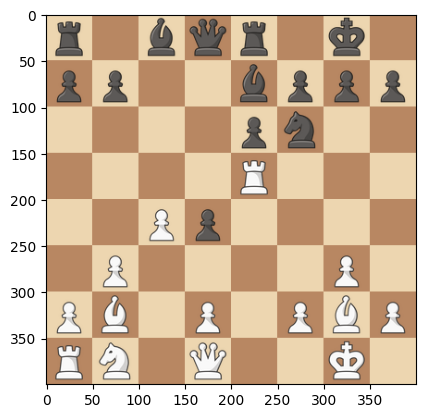

In [12]:
plt.imshow(cv2.cvtColor(gt_board, cv2.COLOR_BGR2RGB))

### Detect edges

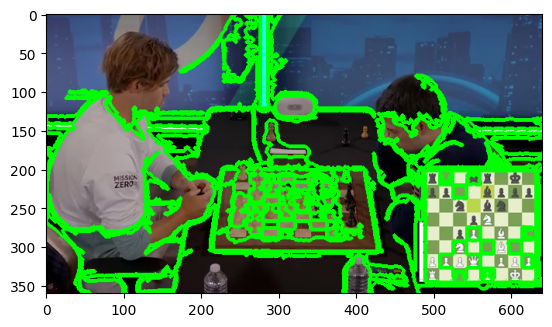

In [4]:
def add_edges(image, area_lim=1000):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0) # Apply Gaussian Blur to reduce noise
    # Get binary image for edge detection. The threshold at each pixel is calculated as the mean - c
    # if pixel > threshold is set to 255, else 0 (white for stand out brighter pixels)
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    # Get list of contour points (numpy array of coordinates) and the hierarchy
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Find contours

    # Find largest countour area
    max_area = 0
    c = 0
    for i in contours:
        area = cv2.contourArea(cv2.UMat(i)) # Calculate area of each contour
        if area > area_lim:
            if area > max_area:
                max_area = area
                best_cnt = i
                # c is the index of the contour to draw
                # (0, 255, 0) color is in BGR format
                # 3 is the thickness
                image = cv2.drawContours(image, contours, c, (0, 255, 0), 3)
        c += 1

    # Create a mask and draw the largest contour
    mask = np.zeros((gray.shape), np.uint8)
    cv2.drawContours(mask, [best_cnt], 0, 255, -1) # Fill (-1) the largest contour in white (255)
    cv2.drawContours(mask, [best_cnt], 0, 0, 2) # Draw the outline of the largest contour in black (0) 

    # Create an output image where only the area inside the largest contour is kept
    out = np.zeros_like(gray)
    out[mask == 255] = gray[mask == 255] # Copy pixel values from gray to out where largest contour is
    blur = cv2.GaussianBlur(out, (11, 11), 0) # Smooth
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2) # Get binary image

    # Loops through contours drawing those with area above 500
    c = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000 / 2:
            cv2.drawContours(image, contours, c, (0, 255, 0), 3) # Draw with green other relevant contours
        c += 1
    return image

image_edges = add_edges(image.copy(), area_lim=10000)

plt.imshow(cv2.cvtColor(image_edges, cv2.COLOR_BGR2RGB))

# Chessboard Predictor

In [29]:
class GTChessboardPredictor():
    def __init__(self, id2label_map,
                 square_size=60,
                 mlruns_dir="../data/mlruns",
                 mlrun_uri=None,
                 run_id=None):
        # mlruns_dir (str, optional): The location to store the MLflow runs.
        #     Defaults to "../data/mlruns".
        # mlrun_uri (str, optional): The URI for the MLflow run.
        #     Defaults to None.
        # run_id (str, optional): The ID of the MLflow run.
        #     Defaults to None.
        
        self.mlruns_dir = mlruns_dir
        self.mlrun_uri = mlrun_uri
        self.run_id = run_id
        self.id2label_map = id2label_map # Map that relates class indices to labels
        self.square_size = square_size

        # # Store all possible prediction for each square
        # self.predictions = [[[] for _ in range(8)] for _ in range(8)]

        # Chess board
        self.board = chess.Board()
        self.board_arr = [
            ["r", "n", "b", "q", "k", "b", "n", "r"],
            ["p", "p", "p", "p", "p", "p", "p", "p"],
            ["0", "0", "0", "0", "0", "0", "0", "0"],
            ["0", "0", "0", "0", "0", "0", "0", "0"],
            ["0", "0", "0", "0", "0", "0", "0", "0"],
            ["0", "0", "0", "0", "0", "0", "0", "0"],
            ["P", "P", "P", "P", "P", "P", "P", "P"],
            ["R", "N", "B", "Q", "K", "B", "N", "R"]
        ]
        self.n_moves = 0

        # Set mlruns dir
        mlflow.set_tracking_uri("file://" + self.mlruns_dir)

        # Load model
        if self.mlrun_uri:
            mlflow.set_tracking_uri(self.mlrun_uri)
        if self.run_id:
            self.model = mlflow.pytorch.load_model("runs:/" + self.run_id + "/best_model")

    def get_legal_moves_and_boards(self):

        # Get legal moves
        legal_moves = self.board.legal_moves

        # Get (move, board arr) for each legal move
        legal_moves_and_boards = []
        for move in legal_moves:
            board_copy = self.board.copy()
            board_copy.push(move)
            legal_fen = board_copy.fen()
            legal_arr = self.fen2arr(legal_fen)
            legal_moves_and_boards.append((move, legal_arr))

        return legal_moves_and_boards

    def get_board_score(self, pred_probs, legal_board_arr):
        # Compute the score for the predicted board arrangement
        # legal_board_arr = legal_board_arr.map(lambda x: np.log(pred_probs.get(x, 0)))
        # score = legal_board_arr.sum()

        score = 0.0
        for row in range(8):
            for col in range(8):
                piece = legal_board_arr[row, col]
                prob = pred_probs[row][col].get(piece, 0)  # Get probability for the piece
                score += np.log(prob)  # Add log probability to the score
        return score

    def get_valid_move_and_board(self, pred_probs, pred_board_arr, legal_moves_and_boards):

        # Get current board array
        current_fen = self.board.fen()
        current_board_arr = self.fen2arr(current_fen)

        # Check if no moves
        if np.array_equal(pred_board_arr, current_board_arr):
            return None, current_board_arr

        # Get score for no move
        no_move_score = self.get_board_score(pred_probs, current_board_arr)
        legal_move = None
        legal_board = current_board_arr
        max_score = no_move_score

        # Get score for each legal move
        for move, legal_arr in legal_moves_and_boards:
            score = self.get_board_score(pred_probs, legal_arr)
            if score > max_score:
                max_score = score
                legal_move = move
                legal_board = legal_arr

        return legal_move, legal_board

    # def identify_illegal_square(self, pred_board_arr):
        
    #     diff_squares = self.get_diff_squares(pred_board_arr)

    #     if diff_squares:
    #         changed = True
    #     else:
    #         changed = False


    # def get_diff_squares(self, pred_board_arr):

    #     diff_squares = []
    #     for row in range(8):
    #         for col in range(8):
    #             if self.board_arr[row][col] != pred_board_arr[row][col]:
    #                 diff_squares.append((row, col))
    #     return diff_squares

    def predict(self, gt_board_image, use_previous_moves=False):

        # Select device
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")  # Apple GPU
        else:
            device = torch.device("cpu")

        print(f"Using device: {device}")

        # Predict without previous moves
        if not use_previous_moves:
            board_arr, _ = self.predict_gt_board(gt_board_image, device)
            fen = self.arr2fen(board_arr)
            return fen

        # Predict with previous moves
        board_arr, pred_probs = self.predict_gt_board(gt_board_image, device)
        legal_moves_and_boards = self.get_legal_moves_and_boards()

        #print("Legal moves and boards: ", legal_moves_and_boards)
        valid_move, legal_board = self.get_valid_move_and_board(pred_probs, board_arr, legal_moves_and_boards)

        print("Valid move: ", valid_move)
        print("Legal board: ", legal_board)

        if valid_move:
            self.board.push(valid_move)
        else:
            print("No move, the board is unchanged.")

        fen = self.arr2fen(legal_board)
        return fen

        # if self.board_arr != board_arr:
            
        #     # Check valid move
        #     valid, changed, wrong_squares = self.check_valid_move(board_arr)
        #     if valid:
        #         self.n_moves += 1
        #         self.board_arr = board_arr

        #     else:
        #         # Try with second guess
        #         second_guess = self.make_second_guess(wrong_squares)
        #         valid, wrong_squares = self.check_valid_move(second_guess)
        #         if valid:
        #             self.n_moves += 1
        #             self.board_arr = second_guess

        # fen = self.arr2fen(board_arr)
        # return fen

    def arr2fen(self, pred_board_arr):
        fen = ""
        for row in pred_board_arr:
            empty_count = 0
            for square in row:
                if square == "0":
                    empty_count += 1
                else:
                    if empty_count > 0:
                        fen += str(empty_count) # Add empty square count
                        empty_count = 0
                    fen += square if len(square) == 1 else "?"  # fallback for unknown
            if empty_count > 0:
                fen += str(empty_count)
            fen += "/"
        return fen[:-1]  # Remove trailing slash
    
    def fen2arr(self, fen):
        # Only use the piece placement part
        fen_piece_placement = fen.split(' ')[0] # rnbqkbnr/pp1ppppp/8/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
        board_arr = np.empty((8, 8), dtype=object)
        rows = fen_piece_placement.split('/')
        for i, row in enumerate(rows):
            col = 0
            for char in row:
                if char.isdigit():
                    for _ in range(int(char)):
                        board_arr[i, col] = "0"  # empty square
                        col += 1
                else:
                    board_arr[i, col] = char
                    col += 1
        return board_arr

    def predict_gt_board(self, gt_board_img, device):

        pred_board_arr = np.empty((8, 8), dtype=object)

        pred_probs = [[{} for _ in range(8)] for _ in range(8)]

        for row in range(8):
            for col in range(8):
                
                # Crop the specific square
                gt_board_img = cv2.resize(gt_board_img, (8 * self.square_size, 8 * self.square_size))
                square_img = gt_board_img[row*self.square_size:(row+1)*self.square_size, col*self.square_size:(col+1)*self.square_size]

                # Predict the square
                square_img = cv2.cvtColor(square_img, cv2.COLOR_BGR2RGB)
                square_img = square_img / 255.0
                square_img = square_img.transpose((2, 0, 1)) # (3, 60, 60)
                square_img_t = torch.tensor(square_img, dtype=torch.float32).unsqueeze(0).to(device)

                with torch.no_grad():
                    square_preds_logits_t = self.model(square_img_t) # (batch size, num_classes)
                    preds_n = square_preds_logits_t.argmax(dim=1).cpu().numpy()
                    #pred_probs = np.softmax(preds, axis=0)
                    square_preds_probs_n = square_preds_logits_t.softmax(dim=1).cpu().numpy()
                    square_pred_probs_dict = {self.id2label_map.get(i, "Unknown"): prob for i, prob in enumerate(square_preds_probs_n[0])}

                # Map the predicted class to the corresponding label
                chosen_square_pred_label = self.id2label_map.get(preds_n[0], "Unknown")
                #print(f"Predicted label for square ({row}, {col}): {predicted_label}")

                # Add to predictions array
                pred_board_arr[row, col] = chosen_square_pred_label

                # Save all predictions probabilities for each square
                pred_probs[row][col] = square_pred_probs_dict

        return pred_board_arr, pred_probs

### Test prediction

Using device: mps


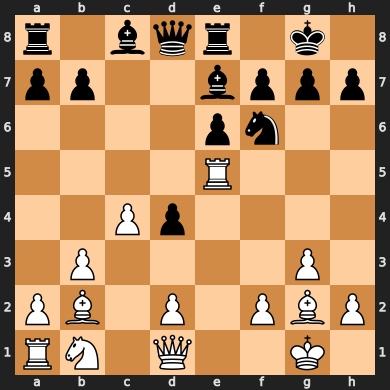

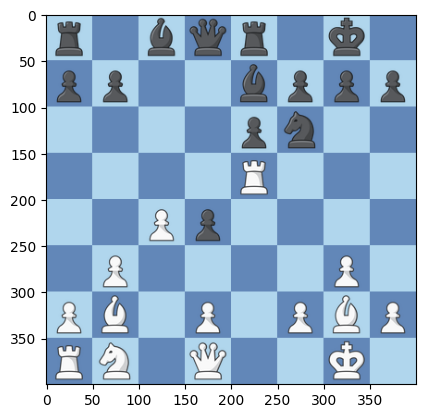

In [31]:
def load_id2label_map(dataset_dir):
    labels_mapping_path = dataset_dir / "labels_mapping.json"

    with open(labels_mapping_path, 'r') as f:
        labels_map = json.load(f)

    id2label = labels_map["id2class"]

    # Convert keys to int
    id2label = {int(k): v for k, v in id2label.items()}

    return id2label

# Load id2label map
DATASET_FOLDER_NAME = "chessboard_2d_rendered_aug"
base_dir = pathlib.Path.cwd().parent
dataset_dir = base_dir / "data" / DATASET_FOLDER_NAME
id2label_map = load_id2label_map(dataset_dir)

# Instance predictor
mlruns_dir = str(base_dir / "data" / "mlruns")
run_id = "36aa38a2ba8a41a5841265e48c030eea"
gt_predictor = GTChessboardPredictor(id2label_map, mlruns_dir=mlruns_dir, run_id=run_id)

# Predict FEN
fen = gt_predictor.predict(gt_board, use_previous_moves=False)

# Plot prediction and ground truth
pred_board = chess.Board()
pred_board.set_fen(fen)

display(pred_board)
plt.imshow(gt_board)

# pgn = io.StringIO(game_info["pgn"])
# chess_game = chess.pgn.read_game(pgn)
# board = chess_game.board()

# Extract gt board and irl board

- `gt`: ground truth board
- `irl`: in real life board

In [32]:
FINAL_DATASET_NAME = "chessboard_irl" 

## Get video frames

In [ ]:
def get_video_frames(video_path, range, step_sec=1.0, loc=None):

    # Load video
    cap = cv2.VideoCapture(str(video_path))

    #fps = cap.get(cv2.CAP_PROP_FPS)

    print(f"Extracting frames from {range[0]} to {range[1]} ....")

    # Get the start and end times in seconds
    start_time = sum(x * int(t) for x, t in zip([60, 1], range[0].split(":")))
    end_time = sum(x * int(t) for x, t in zip([60, 1], range[1].split(":")))

    # Create frames dir
    video_name = pathlib.Path(video_path).stem
    frames_dir = pathlib.Path(video_path).parent / f"{video_name}_frames"
    frames_dir.mkdir(exist_ok=True)

    # Seek to start time
    cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

    # Get the frames for the specified range
    current_time = start_time
    while current_time <= end_time:
        ret, frame = cap.read()
        if not ret:
            break

        minute = int(current_time // 60)
        seconds = int(current_time % 60)
        milliseconds = int((current_time * 1000) % 1000)

        # Crop frame if loc
        if loc:
            x, y, w, h = loc
            frame = frame[y:y+h, x:x+w]

        cv2.imwrite(str(frames_dir / f"frame_{minute:03d}_{seconds:02d}_{milliseconds:03d}.jpg"), frame)

        # Skip to the next frame
        current_time += step_sec
        cap.set(cv2.CAP_PROP_POS_MSEC, current_time * 1000)

    cap.release()


# Example
# video_id = "UpeMdJYyOHg"
# range = ["23:59", "24:02"]
# base_dir = pathlib.Path.cwd()
# save_dir = base_dir / "data" / video_id

# video_path = save_dir / f"{video_id}.mp4"
# loc = [850, 100, 1200, 1000] # x, y, w, h
# get_video_frames(video_path, range, step_sec=0.1, loc=loc)

### Video Board Extractor

In [33]:
from tqdm import tqdm
from loguru import logger
import pandas as pd
import subprocess

def line_flattener(line):
    # Replace consecutive '1's with their count in each line of the FEN string
    linenew = line
    for i in range(9, 1, -1):
        linenew = linenew.replace("1" * i, str(i))
    return linenew

class VideoBoardExtractor:
    def __init__(
        self,
        video_path: str,
        gt_board_loc=[20, 415, 440, 835],
        irl_board_loc=[420, 720, 350, 1280],
        time_range=None,
        step_sec=1.0,
        predict_fen=False,
        store_masks=False,
        store_gt_boards=False,
        store_irl_boards=False,
        store_irl_video=False,
        save_img_freq=False,
        at_first_gt_frame=True,
        purge_output_dir=True,
        store_dir="../data/processed",
        gt_board_predictor=None,
    ):
        """Object for extracting features from a chess video mp4 file.
        The video is expected to have a ground truth board placed at
        the top middle of the screen and the live in real life board
        at the bottom middle of the screen. Video should be in mp4 format.

        Args:
            video_fn (str): The video filename .mp4 format
            gt_board_loc (list, optional): The location of the ground
                truth board. Defaults to [20, 415, 440, 835].
            irl_board_loc (list, optional): The location of the real
                life board. Defaults to [420, -1, 350, -350].
            predict_fen (bool, optional): Option to predict the FEN board
                setup on frames where a ground truth board exists.
                Defaults to False.
            store_masks (bool, optional): Option to store a masked image
                of the video for each frame. Defaults to False.
            store_gt_boards (bool, optional): Option to store the ground truth
                boards image from the video. Defaults to False.
            store_irl_video (bool, optional): Option to store the irl board as
                a video file.
            store_irl_boards (bool, optional): Option to store the real life
                board imags. Defaults to False.
            save_img_freq (int or bool):
                Will save the image of the video frame every `save_img_freq` to
                the `img` data directory
            at_first_gt_frame (bool, optional): If False will try to automatically
                detect the first frame where there is a ground truth board.
            purge_output_dir (bool, optional): If True will delete everything in the
                output directory for the video.
            store_dir (str, optional): The location to store the outputs of
                the processing. Will be placed in a subfolder with the video_id.
                Defaults to "../data/processed".
            gt_board_predictor (GTChessboardPredictor, optional): The ground truth board predictor.
        """
        # Logging
        self.logger = logger

        # Video extraction
        self.time_range = time_range
        self.step_sec = step_sec
        self.video_path = video_path
        self.vidcap = None
        self.first_frame_img = None
        self.avg_frame_color = {}
        self.last_frame_color = None

        # FEN prediction utilities
        self.frame_change = None
        self.at_first_gt_frame = at_first_gt_frame
        self.gt_board_loc = gt_board_loc
        self.predict_fen = predict_fen
        self.last_fen = None

        # FEN prediction model
        if predict_fen:
            self.fens = {}
            self.fen_predictor = gt_board_predictor

        # Result storage
        self.store_dir = store_dir
        self.video_name = video_path.split("/")[-1].strip(".mp4")
        self.full_store_dir = f"{self.store_dir}/{self.video_name}"
        self.store_masks = store_masks
        # if store_masks:
        # self.masks = {}
        self.store_gt_boards = store_gt_boards
        # if store_gt_boards:
        # self.gt_boards = {}
        # if store_irl_boards:
        # self.irl_boards = {}
        self.irl_board_loc = irl_board_loc
        self.store_irl_boards = store_irl_boards
        self.store_irl_video = store_irl_video
        self.save_img_freq = save_img_freq

        
        if store_irl_boards or store_gt_boards or store_masks or store_irl_video:
            self.make_dirs(purge_output_dir)
        if self.store_irl_video:
            VIDEO_CODEC = "MP4V"
            fps = 30
            irl_height = int(irl_board_loc[1] - irl_board_loc[0])
            irl_width = int(irl_board_loc[3] - irl_board_loc[2])
            self.logger.info(f"IRL height: {irl_height} width: {irl_width}")
            self.irl_video = cv2.VideoWriter(
                f"{self.full_store_dir}/irl/irl_temp.mp4",
                cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                fps,
                (irl_width, irl_height),
            )
        else:
            self.irl_video = None

        self.logger.info(f"Created video extractor for {self.video_path}")
        self.logger.info(f"IRL Board Location: {irl_board_loc}")
        self.logger.info(f"GT Board Location: {gt_board_loc}")

    def load_videocap(self):
        self.logger.info("Loading video capture")
        self.vidcap = cv2.VideoCapture(self.video_path)
        self.frame_count = self.vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
        self.fps = self.vidcap.get(cv2.CAP_PROP_FPS)

    def save_video_img(self, frame, image):
        if frame % self.save_img_freq == 0:
            img_fn = f"{self.full_store_dir}/imgs/{frame}.png"
            cv2.imwrite(img_fn, image)

    def compress_irl_video(self):
        self.logger.info("Compressing our output irl video")
        tmp_output_path = f"{self.full_store_dir}/irl/irl_temp.mp4"
        output_path = f"{self.full_store_dir}/irl/irl.mp4"
        subprocess.run(
            [
                "ffmpeg",
                "-i",
                tmp_output_path,
                "-crf",
                "18",
                "-preset",
                "veryfast",
                "-vcodec",
                "libx264",
                output_path,
                # "-loglevel",
                # "quiet",
            ]
        )
        # os.remove(tmp_output_path)

    def process_video(
        self, stop_on_first_board=False
    ):
        self.logger.info("Proccessing video capture")

        # Load video
        self.load_videocap()

        # Time range
        if self.time_range:
            # Get the start and end times in seconds
            start_time = sum(x * int(t) for x, t in zip([60, 1], self.time_range[0].split(":")))
            end_time = sum(x * int(t) for x, t in zip([60, 1], self.time_range[1].split(":")))
            print(f"Extracting frames from {self.time_range[0]} to {self.time_range[1]} ....")
        else:
            start_time = 0
            end_time = self.frame_count / self.fps
            print(f"Extracting frames from start to end of video: {self.video_name}")

        # Seek to start time
        self.vidcap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

        # Get the frames for the specified range
        total_seconds = end_time - start_time
        max_frame = int(total_seconds / self.step_sec)
        pbar = tqdm(total=max_frame)
        current_time = start_time
        frame = 0
        while current_time <= end_time:
            success, image = self.vidcap.read()
            if not success:
                pbar.close()
                break

            _ = self.process_frame(image, frame)

            # minute = int(current_time // 60)
            # seconds = int(current_time % 60)
            # milliseconds = int((current_time * 1000) % 1000)
            #cv2.imwrite(str(frames_dir / f"frame_{minute:03d}_{seconds:02d}_{milliseconds:03d}.jpg"), frame)

            # Skip to the next frame
            current_time += self.step_sec
            pbar.update(1)
            frame += 1
            self.vidcap.set(cv2.CAP_PROP_POS_MSEC, current_time * 1000)

        self.vidcap.release()
        pbar.close()

        if self.store_irl_video:
            self.irl_video.release()
            self.compress_irl_video()

    def get_average_color(self, img, frame):
        self.logger.info("Getting the average color of frame")

        average = img.mean(axis=0).mean(axis=0)

        self.avg_frame_color[frame] = average

        if self.last_frame_color is None:
            self.last_frame_color = np.mean(average)
            return

        self.frame_change = np.mean(average) - self.last_frame_color
        if self.frame_change > 50:
            self.at_first_gt_frame = True
            # print(f'AGHHHH - FRAME {frame}')
        self.last_frame_color = np.mean(average)

    def save_fen_csv(self):
        pd.Series(self.fens).to_frame("fen").reset_index().rename(
            columns={"index": "frame"}
        ).to_csv(f"{self.full_store_dir}/fen.csv")

    @logger.catch
    def extract_fen(self, gt_board, frame):
        try:
            fen = self.fen_predictor.predict(gt_board, use_previous_moves=True)
            if fen is None:
                return False, True
            flat_fen = "/".join([line_flattener(line) for line in fen.split("/")])
            self.fens[frame] = flat_fen

            if self.last_fen != flat_fen:
                changed = True
            else:
                changed = False
            self.last_fen = flat_fen
            self.save_fen_csv()
        except Exception as e:
            logger.warning("Could not detect the FEN at this frame")
            logger.warning(f"Exception thrown {e}")
            return False, True
        return True, changed

    def make_dirs(self, purge_output_dir):
        self.logger.info("Making storage directories")
        dirs_to_make = []
        dirs_to_make.append(f"{self.full_store_dir}/gt/")
        dirs_to_make.append(f"{self.full_store_dir}/irl/")
        dirs_to_make.append(f"{self.full_store_dir}/mask/")
        dirs_to_make.append(f"{self.full_store_dir}/imgs/")

        for d in dirs_to_make:
            if os.path.exists(d) and purge_output_dir:
                shutil.rmtree(d)
            if not os.path.exists(d):
                os.makedirs(d)

    def process_frame(self, image, frame):
        if frame == 1 and not self.at_first_gt_frame:
            self.first_frame_img = image.copy()
        if self.at_first_gt_frame is False:
            self.get_average_color(image, frame)
        self.this_frame_img = image.copy()
        self.masked_img, self.gt_board, self.irl_board = self.extract_gt_board(
            image, self.gt_board_loc, self.irl_board_loc
        )
        if self.predict_fen:
            succeed, fen_changed = self.extract_fen(self.gt_board, frame)

            if self.store_gt_boards and len(self.gt_board) != 0:
                # print("Saving:")
                # print(f"{self.full_store_dir}/gt/{self.video_id}_{frame}.png")
                cv2.imwrite(
                    f"{self.full_store_dir}/gt/{self.video_name}_{frame}.jpg",
                    self.gt_board,
                )

            if self.store_masks and len(self.masked_img) != 0:
                cv2.imwrite(
                    f"{self.full_store_dir}/mask/{self.video_name}_{frame}.jpg",
                    self.masked_img,
                )
            if self.irl_board is not None:
                if self.store_irl_boards and len(self.irl_board) != 0:
                    cv2.imwrite(
                        f"{self.full_store_dir}/irl/{self.video_name}_{frame}.jpg",
                        self.irl_board,
                    )
                if self.store_irl_video:
                    # print("Writing IRL Frame")
                    WHITE = (255, 255, 255)
                    cv2.putText(
                        self.irl_board,
                        str(frame),
                        (5, 20),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        WHITE,
                        thickness=1,
                    )
                    self.irl_video.write(self.irl_board)

            return succeed
        return True

    def extract_gt_board(self, img, gt_board_loc, irl_board_loc):
        top, bottom, left, right = gt_board_loc
        gt_board = img[top:bottom, left:right, :].copy()
        irl_top, irl_bottom, irl_left, irl_right = irl_board_loc
        irl_board = img[irl_top:irl_bottom, irl_left:irl_right, :].copy()

        # if not first image fill with black
        if self.first_frame_img is None:
            img[top:bottom, left:right, :] = 0
            return img, gt_board, irl_board

        # If first image fill with first frame
        img[top:bottom, left:right, :] = self.first_frame_img[top:bottom, left:right, :]
        return img, gt_board, irl_board

In [34]:
current_dir = pathlib.Path.cwd()
base_dir = current_dir.parent
video_name = "KtTtQN8-96c"
video_path = base_dir / "data" / "videos" / f"{video_name}.mp4"


gt_board_loc = [203, 346, 489, 632] # [y1, y2, x1, x2]
irl_board_loc = [180, 310,  200, 450] # [y1, y2, x1, x2]

vbe = VideoBoardExtractor(
        video_path=str(video_path),
        gt_board_loc=gt_board_loc,
        irl_board_loc=irl_board_loc,
        time_range=["0:22", "0:50"], # 4:06
        step_sec=0.5,
        predict_fen=True,
        store_masks=True,
        store_gt_boards=True,
        store_irl_boards=True,
        store_irl_video=False,
        save_img_freq=True,
        at_first_gt_frame=True,
        purge_output_dir=True,
        store_dir="../data/processed",
        gt_board_predictor=gt_predictor
    )

vbe.process_video()

2025-08-21 19:43:17.694 | INFO     | __main__:make_dirs:260 - Making storage directories
2025-08-21 19:43:17.717 | INFO     | __main__:__init__:125 - Created video extractor for /Users/alexquiroga/Storage/Github/DEEP_LEARNING/COMPUTER_VISION/chess-vision/chess-main/data/videos/KtTtQN8-96c.mp4
2025-08-21 19:43:17.717 | INFO     | __main__:__init__:126 - IRL Board Location: [180, 310, 200, 450]
2025-08-21 19:43:17.717 | INFO     | __main__:__init__:127 - GT Board Location: [203, 346, 489, 632]
2025-08-21 19:43:17.718 | INFO     | __main__:process_video:165 - Proccessing video capture
2025-08-21 19:43:17.718 | INFO     | __main__:load_videocap:130 - Loading video capture


Extracting frames from 0:22 to 0:50 ....


  0%|          | 0/56 [00:00<?, ?it/s]

Using device: mps


  2%|▏         | 1/56 [00:00<00:35,  1.54it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' 'p' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
No move, the board is unchanged.
Using device: mps


  4%|▎         | 2/56 [00:01<00:32,  1.66it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' 'p' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
No move, the board is unchanged.
Using device: mps


  5%|▌         | 3/56 [00:01<00:29,  1.80it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' 'p' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
No move, the board is unchanged.
Using device: mps


  7%|▋         | 4/56 [00:02<00:30,  1.70it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' 'p' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
No move, the board is unchanged.
Using device: mps


  9%|▉         | 5/56 [00:02<00:30,  1.66it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' 'p' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
No move, the board is unchanged.
Using device: mps


 11%|█         | 6/56 [00:03<00:29,  1.69it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' 'p' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' 'P' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
No move, the board is unchanged.
Using device: mps


 12%|█▎        | 7/56 [00:04<00:30,  1.59it/s]

Valid move:  e2e4
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' 'p' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 14%|█▍        | 8/56 [00:04<00:30,  1.57it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' 'p' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 16%|█▌        | 9/56 [00:05<00:31,  1.50it/s]

Valid move:  e7e5
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
Using device: mps


 18%|█▊        | 10/56 [00:06<00:29,  1.53it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
No move, the board is unchanged.
Using device: mps


 20%|█▉        | 11/56 [00:06<00:29,  1.51it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
No move, the board is unchanged.
Using device: mps


 21%|██▏       | 12/56 [00:07<00:28,  1.53it/s]

Valid move:  g1f3
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'N' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 23%|██▎       | 13/56 [00:08<00:26,  1.65it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' 'n' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'N' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 25%|██▌       | 14/56 [00:08<00:27,  1.53it/s]

Valid move:  g8f6
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'N' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
Using device: mps


 27%|██▋       | 15/56 [00:09<00:24,  1.68it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'N' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


 29%|██▊       | 16/56 [00:10<00:25,  1.59it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'N' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


 30%|███       | 17/56 [00:10<00:27,  1.42it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'N' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


 32%|███▏      | 18/56 [00:11<00:24,  1.55it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'N' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


 34%|███▍      | 19/56 [00:12<00:24,  1.51it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'N' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


 36%|███▌      | 20/56 [00:12<00:21,  1.65it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'N' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


 38%|███▊      | 21/56 [00:13<00:21,  1.60it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'p' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' 'N' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


 39%|███▉      | 22/56 [00:14<00:22,  1.51it/s]

Valid move:  f3e5
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 41%|████      | 23/56 [00:14<00:22,  1.49it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'P' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 43%|████▎     | 24/56 [00:15<00:21,  1.48it/s]

Valid move:  f6e4
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 45%|████▍     | 25/56 [00:16<00:20,  1.50it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 46%|████▋     | 26/56 [00:16<00:19,  1.55it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 48%|████▊     | 27/56 [00:17<00:17,  1.67it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 50%|█████     | 28/56 [00:17<00:17,  1.56it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 52%|█████▏    | 29/56 [00:18<00:17,  1.53it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 54%|█████▎    | 30/56 [00:19<00:16,  1.54it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 55%|█████▌    | 31/56 [00:19<00:14,  1.67it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 57%|█████▋    | 32/56 [00:20<00:15,  1.54it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 59%|█████▉    | 33/56 [00:20<00:14,  1.64it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 61%|██████    | 34/56 [00:21<00:14,  1.54it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 62%|██████▎   | 35/56 [00:22<00:12,  1.65it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 64%|██████▍   | 36/56 [00:22<00:12,  1.57it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 66%|██████▌   | 37/56 [00:23<00:11,  1.62it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 68%|██████▊   | 38/56 [00:24<00:11,  1.52it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 70%|██████▉   | 39/56 [00:24<00:11,  1.54it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 71%|███████▏  | 40/56 [00:25<00:10,  1.53it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 73%|███████▎  | 41/56 [00:26<00:09,  1.60it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 75%|███████▌  | 42/56 [00:26<00:07,  1.76it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 77%|███████▋  | 43/56 [00:27<00:07,  1.69it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 79%|███████▊  | 44/56 [00:28<00:08,  1.48it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' 'P' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 80%|████████  | 45/56 [00:28<00:07,  1.42it/s]

Valid move:  d2d3
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 82%|████████▏ | 46/56 [00:29<00:06,  1.49it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 84%|████████▍ | 47/56 [00:29<00:05,  1.55it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 86%|████████▌ | 48/56 [00:30<00:05,  1.58it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 88%|████████▊ | 49/56 [00:31<00:04,  1.73it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 89%|████████▉ | 50/56 [00:31<00:03,  1.73it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' 'n' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 91%|█████████ | 51/56 [00:32<00:03,  1.63it/s]

Valid move:  e4f6
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 93%|█████████▎| 52/56 [00:32<00:02,  1.66it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 95%|█████████▍| 53/56 [00:33<00:01,  1.59it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 96%|█████████▋| 54/56 [00:34<00:01,  1.65it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
 98%|█████████▊| 55/56 [00:34<00:00,  1.60it/s]

Valid move:  d3d4
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
100%|██████████| 56/56 [00:35<00:00,  1.66it/s]

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.
Using device: mps


/var/folders/68/45xvb1rn0tg8rjpx4dv6zdh00000gn/T/ipykernel_79094/22671332.py:72: RuntimeWarning: divide by zero encountered in log
  score += np.log(prob)  # Add log probability to the score
57it [00:36,  1.58it/s]                        

Valid move:  None
Legal board:  [['r' 'n' 'b' 'q' 'k' 'b' '0' 'r']
 ['p' 'p' 'p' 'p' '0' 'p' 'p' 'p']
 ['0' '0' '0' '0' '0' 'n' '0' '0']
 ['0' '0' '0' '0' 'N' '0' '0' '0']
 ['0' '0' '0' 'P' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['P' 'P' 'P' '0' '0' 'P' 'P' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' '0' 'R']]
No move, the board is unchanged.


# Multiple videos

- Alan Pichot vs Faustio Oro: https://www.youtube.com/watch?v=JSnfTfK__Bc
- Magnus Carlsen vs Judit Polgar: https://www.youtube.com/watch?v=rrPfmSWlAPM

In [2]:
def pull_video(video_id, save_dir):
    out_fn = f"{save_dir}/{video_id}.mp4"
    if os.path.exists(out_fn):
        return

    yt = YouTube(
        f"https://www.youtube.com/watch?v={video_id}"
    )
    print(f"Downloading video: {yt.title}")

    stream = yt.streams.get_highest_resolution()
    stream.download()
    fn = stream.default_filename
    shutil.move(fn, out_fn)

def get_frame(video_path, time_sec):
    vidcap = cv2.VideoCapture(video_path)
    frame_count = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, int(fps * time_sec))
    success, image = vidcap.read()
    vidcap.release()
    if success:
        return image
    else:
        return None
    
def extract_gt_board(img, gt_board_loc, irl_board_loc):
    top, bottom, left, right = gt_board_loc
    gt_board = img[top:bottom, left:right, :].copy()
    irl_top, irl_bottom, irl_left, irl_right = irl_board_loc
    irl_board = img[irl_top:irl_bottom, irl_left:irl_right, :].copy()
    # if self.first_frame_img is None:
    #     img[top:bottom, left:right, :] = 0
    #     return img, gt_board, irl_board
    #img[top:bottom, left:right, :] = self.first_frame_img[top:bottom, left:right, :]
    return gt_board, irl_board

def load_id2label_map(dataset_dir):
    labels_mapping_path = dataset_dir / "labels_mapping.json"

    with open(labels_mapping_path, 'r') as f:
        labels_map = json.load(f)

    id2label = labels_map["id2class"]

    # Convert keys to int
    id2label = {int(k): v for k, v in id2label.items()}

    return id2label

In [70]:
class GTChessboardPredictor():
    def __init__(self, id2label_map,
                 square_size=60,
                 mlruns_dir="../data/mlruns",
                 mlrun_uri=None,
                 run_id=None):
        # mlruns_dir (str, optional): The location to store the MLflow runs.
        #     Defaults to "../data/mlruns".
        # mlrun_uri (str, optional): The URI for the MLflow run.
        #     Defaults to None.
        # run_id (str, optional): The ID of the MLflow run.
        #     Defaults to None.
        
        self.mlruns_dir = mlruns_dir
        self.mlrun_uri = mlrun_uri
        self.run_id = run_id
        self.id2label_map = id2label_map # Map that relates class indices to labels
        self.square_size = square_size

        # # Store all possible prediction for each square
        # self.predictions = [[[] for _ in range(8)] for _ in range(8)]

        # Chess board
        self.board = chess.Board()
        self.board_arr = [
            ["r", "n", "b", "q", "k", "b", "n", "r"],
            ["p", "p", "p", "p", "p", "p", "p", "p"],
            ["0", "0", "0", "0", "0", "0", "0", "0"],
            ["0", "0", "0", "0", "0", "0", "0", "0"],
            ["0", "0", "0", "0", "0", "0", "0", "0"],
            ["0", "0", "0", "0", "0", "0", "0", "0"],
            ["P", "P", "P", "P", "P", "P", "P", "P"],
            ["R", "N", "B", "Q", "K", "B", "N", "R"]
        ]
        self.n_moves = 0

        # Set mlruns dir
        mlflow.set_tracking_uri("file://" + self.mlruns_dir)

        # Load model
        if self.mlrun_uri:
            mlflow.set_tracking_uri(self.mlrun_uri)
        if self.run_id:
            self.model = mlflow.pytorch.load_model("runs:/" + self.run_id + "/best_model")

    def get_legal_moves_and_boards(self):

        # Get legal moves
        legal_moves = self.board.legal_moves

        # Get (move, board arr) for each legal move
        legal_moves_and_boards = []
        for move in legal_moves:
            board_copy = self.board.copy()
            board_copy.push(move)
            legal_fen = board_copy.fen()
            legal_arr = self.fen2arr(legal_fen)
            legal_moves_and_boards.append((move, legal_arr))

        return legal_moves_and_boards

    def get_board_score(self, pred_probs, legal_board_arr):
        # Compute the score for the predicted board arrangement
        # legal_board_arr = legal_board_arr.map(lambda x: np.log(pred_probs.get(x, 0)))
        # score = legal_board_arr.sum()

        score = 0.0
        for row in range(8):
            for col in range(8):
                piece = legal_board_arr[row, col]
                prob = pred_probs[row][col].get(piece, 0)  # Get probability for the piece
                score += np.log(prob + 1e-8)  # Add log probability to the score
        return score

    def get_valid_move_and_board(self, pred_probs, pred_board_arr, legal_moves_and_boards):

        # Get current board array
        current_fen = self.board.fen()
        current_board_arr = self.fen2arr(current_fen)

        # Check if no moves
        if np.array_equal(pred_board_arr, current_board_arr):
            return None, current_board_arr

        # Get score for no move
        no_move_score = self.get_board_score(pred_probs, current_board_arr)
        legal_move = None
        legal_board = current_board_arr
        max_score = no_move_score

        # Get score for each legal move
        for move, legal_arr in legal_moves_and_boards:
            score = self.get_board_score(pred_probs, legal_arr)
            if score > max_score:
                max_score = score
                legal_move = move
                legal_board = legal_arr

        return legal_move, legal_board

    def predict(self, gt_board_image, use_previous_moves=False, verbose=False):

        # Select device
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")  # Apple GPU
        else:
            device = torch.device("cpu")

        if verbose:
            print(f"Using device: {device}")

        # Predict without previous moves
        if not use_previous_moves:
            board_arr, _ = self.predict_gt_board(gt_board_image, device)
            fen = self.arr2fen(board_arr)
            return fen, True

        # Predict with previous moves
        board_arr, pred_probs = self.predict_gt_board(gt_board_image, device)
        legal_moves_and_boards = self.get_legal_moves_and_boards()

        #print("Legal moves and boards: ", legal_moves_and_boards)
        valid_move, legal_board = self.get_valid_move_and_board(pred_probs, board_arr, legal_moves_and_boards)

        if verbose:
            print("Valid move: ", valid_move)
            print("Legal board: ", legal_board)

        changed = False
        if valid_move:
            changed = True
            self.board.push(valid_move)
        else:
            if verbose:
                print("No move, the board is unchanged.")

        fen = self.arr2fen(legal_board)
        return fen, changed

    def arr2fen(self, pred_board_arr):
        fen = ""
        for row in pred_board_arr:
            empty_count = 0
            for square in row:
                if square == "0":
                    empty_count += 1
                else:
                    if empty_count > 0:
                        fen += str(empty_count) # Add empty square count
                        empty_count = 0
                    fen += square if len(square) == 1 else "?"  # fallback for unknown
            if empty_count > 0:
                fen += str(empty_count)
            fen += "/"
        return fen[:-1]  # Remove trailing slash
    
    def fen2arr(self, fen):
        # Only use the piece placement part
        fen_piece_placement = fen.split(' ')[0] # rnbqkbnr/pp1ppppp/8/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
        board_arr = np.empty((8, 8), dtype=object)
        rows = fen_piece_placement.split('/')
        for i, row in enumerate(rows):
            col = 0
            for char in row:
                if char.isdigit():
                    for _ in range(int(char)):
                        board_arr[i, col] = "0"  # empty square
                        col += 1
                else:
                    board_arr[i, col] = char
                    col += 1
        return board_arr

    def predict_gt_board(self, gt_board_img, device):

        pred_board_arr = np.empty((8, 8), dtype=object)

        pred_probs = [[{} for _ in range(8)] for _ in range(8)]

        for row in range(8):
            for col in range(8):
                
                # Crop the specific square
                gt_board_img = cv2.resize(gt_board_img, (8 * self.square_size, 8 * self.square_size))
                square_img = gt_board_img[row*self.square_size:(row+1)*self.square_size, col*self.square_size:(col+1)*self.square_size]

                # Predict the square
                square_img = cv2.cvtColor(square_img, cv2.COLOR_BGR2RGB)
                square_img = square_img / 255.0
                square_img = square_img.transpose((2, 0, 1)) # (3, 60, 60)
                square_img_t = torch.tensor(square_img, dtype=torch.float32).unsqueeze(0).to(device)

                with torch.no_grad():
                    square_preds_logits_t = self.model(square_img_t) # (batch size, num_classes)
                    preds_n = square_preds_logits_t.argmax(dim=1).cpu().numpy()
                    #pred_probs = np.softmax(preds, axis=0)
                    square_preds_probs_n = square_preds_logits_t.softmax(dim=1).cpu().numpy()
                    square_pred_probs_dict = {self.id2label_map.get(i, "Unknown"): prob for i, prob in enumerate(square_preds_probs_n[0])}

                # Map the predicted class to the corresponding label
                chosen_square_pred_label = self.id2label_map.get(preds_n[0], "Unknown")
                #print(f"Predicted label for square ({row}, {col}): {predicted_label}")

                # Add to predictions array
                pred_board_arr[row, col] = chosen_square_pred_label

                # Save all predictions probabilities for each square
                pred_probs[row][col] = square_pred_probs_dict

        return pred_board_arr, pred_probs

In [71]:
import chess.svg
from tqdm import tqdm
from loguru import logger
import pandas as pd
import subprocess
import cairosvg

def line_flattener(line):
    # Replace consecutive '1's with their count in each line of the FEN string
    linenew = line
    for i in range(9, 1, -1):
        linenew = linenew.replace("1" * i, str(i))
    return linenew

def save_video(output_video_frames, output_video_path, fps=2):
    output_dir = output_video_path.rsplit("/", 1)[0]
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fourcc = cv2.VideoWriter_fourcc(
        *"MJPG"
    )  # Sets the video codec using OpenCV's VideoWriter_fourcc
    # MJPG is a codec (Motion JPEG) and * unpacks the string so it's passed as separate characters to the function
    out = cv2.VideoWriter(
        output_video_path,
        fourcc,  #
        fps,  # 24 FPS
        (
            output_video_frames[0].shape[1],
            output_video_frames[0].shape[0],
        ),  # (width, height)
    )
    for frame in output_video_frames:
        out.write(frame)
    out.release()

class VideoBoardExtractor:
    def __init__(
        self,
        video_path: str,
        gt_board_loc=[20, 415, 440, 835],
        irl_board_loc=[420, 720, 350, 1280],
        time_range=None,
        step_sec=1.0,
        predict_fen=False,
        store_masks=False,
        store_gt_boards=False,
        store_gt_video=False,
        store_irl_boards=False,
        store_irl_video=False,
        store_pred_boards=False,
        store_pred_video=False,
        save_img_freq=False,
        at_first_gt_frame=True,
        purge_output_dir=True,
        store_dir="../data/processed",
        gt_board_predictor=None,
    ):
        """Object for extracting features from a chess video mp4 file.
        The video is expected to have a ground truth board placed at
        the top middle of the screen and the live in real life board
        at the bottom middle of the screen. Video should be in mp4 format.

        Args:
            video_fn (str): The video filename .mp4 format
            gt_board_loc (list, optional): The location of the ground
                truth board. Defaults to [20, 415, 440, 835].
            irl_board_loc (list, optional): The location of the real
                life board. Defaults to [420, -1, 350, -350].
            predict_fen (bool, optional): Option to predict the FEN board
                setup on frames where a ground truth board exists.
                Defaults to False.
            store_masks (bool, optional): Option to store a masked image
                of the video for each frame. Defaults to False.
            store_gt_boards (bool, optional): Option to store the ground truth
                boards image from the video. Defaults to False.
            store_irl_video (bool, optional): Option to store the irl board as
                a video file.
            store_irl_boards (bool, optional): Option to store the real life
                board imags. Defaults to False.
            save_img_freq (int or bool):
                Will save the image of the video frame every `save_img_freq` to
                the `img` data directory
            at_first_gt_frame (bool, optional): If False will try to automatically
                detect the first frame where there is a ground truth board.
            purge_output_dir (bool, optional): If True will delete everything in the
                output directory for the video.
            store_dir (str, optional): The location to store the outputs of
                the processing. Will be placed in a subfolder with the video_id.
                Defaults to "../data/processed".
            gt_board_predictor (GTChessboardPredictor, optional): The ground truth board predictor.
        """
        # Logging
        self.logger = logger

        # Video extraction
        self.time_range = time_range
        self.step_sec = step_sec
        self.video_path = video_path
        self.vidcap = None
        self.first_frame_img = None
        self.avg_frame_color = {}
        self.last_frame_color = None

        # FEN prediction utilities
        self.frame_change = None
        self.at_first_gt_frame = at_first_gt_frame
        self.gt_board_loc = gt_board_loc
        self.predict_fen = predict_fen
        self.last_fen = None
        self.is_first_frame = True

        # FEN prediction model
        if predict_fen:
            self.fens = {}
            self.fen_predictor = gt_board_predictor

        # Result storage
        self.store_dir = store_dir
        self.video_name = video_path.split("/")[-1].strip(".mp4")
        self.full_store_dir = f"{self.store_dir}/{self.video_name}"
        self.store_masks = store_masks
        self.store_gt_boards = store_gt_boards
        self.store_gt_video = store_gt_video
        self.store_pred_boards = store_pred_boards
        self.store_pred_video = store_pred_video
        self.irl_board_loc = irl_board_loc
        self.store_irl_boards = store_irl_boards
        self.store_irl_video = store_irl_video
        self.save_img_freq = save_img_freq

        
        if store_irl_boards or store_gt_boards or store_masks or store_irl_video:
            self.make_dirs(purge_output_dir)
        if self.store_irl_video:
            VIDEO_CODEC = "MP4V"
            fps = 30
            irl_height = int(irl_board_loc[1] - irl_board_loc[0])
            irl_width = int(irl_board_loc[3] - irl_board_loc[2])
            self.logger.info(f"IRL height: {irl_height} width: {irl_width}")
            self.irl_video = cv2.VideoWriter(
                f"{self.full_store_dir}/irl/irl_temp.mp4",
                cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                fps,
                (irl_width, irl_height),
            )
        else:
            self.irl_video = None

        self.logger.info(f"Created video extractor for {self.video_path}")
        self.logger.info(f"IRL Board Location: {irl_board_loc}")
        self.logger.info(f"GT Board Location: {gt_board_loc}")

    def load_videocap(self):
        self.logger.info("Loading video capture")
        self.vidcap = cv2.VideoCapture(self.video_path)
        self.frame_count = self.vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
        self.fps = self.vidcap.get(cv2.CAP_PROP_FPS)

    def save_video_img(self, frame, image):
        if frame % self.save_img_freq == 0:
            img_fn = f"{self.full_store_dir}/imgs/{frame}.png"
            cv2.imwrite(img_fn, image)

    def compress_irl_video(self):
        self.logger.info("Compressing our output irl video")
        tmp_output_path = f"{self.full_store_dir}/irl/irl_temp.mp4"
        output_path = f"{self.full_store_dir}/irl/irl.mp4"
        subprocess.run(
            [
                "ffmpeg",
                "-i",
                tmp_output_path,
                "-crf",
                "18",
                "-preset",
                "veryfast",
                "-vcodec",
                "libx264",
                output_path,
                # "-loglevel",
                # "quiet",
            ]
        )
        # os.remove(tmp_output_path)

    def process_video(
        self, stop_on_first_board=False
    ):
        self.logger.info("Proccessing video capture")

        # Load video
        self.load_videocap()

        # Time range
        if self.time_range:
            # Get the start and end times in seconds (format 02:21)
            # start_time = sum(x * int(t) for x, t in zip([60, 1], self.time_range[0].split(":")))
            # end_time = sum(x * int(t) for x, t in zip([60, 1], self.time_range[1].split(":")))
            # print(f"Extracting frames from {self.time_range[0]} to {self.time_range[1]} ....")

            # Get the start and end times in seconds (format 02:21:00)
            start_time = sum(x * int(t) for x, t in zip([60, 1, 0.01], self.time_range[0].split(":")))
            end_time = sum(x * int(t) for x, t in zip([60, 1, 0.01], self.time_range[1].split(":")))
            print(f"Extracting frames from {self.time_range[0]} to {self.time_range[1]} ....")
        else:
            start_time = 0
            end_time = self.frame_count / self.fps
            print(f"Extracting frames from start to end of video: {self.video_name}")

        # Seek to start time
        self.vidcap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

        # Get the frames for the specified range
        total_seconds = end_time - start_time
        max_frame = int(total_seconds / self.step_sec)
        pbar = tqdm(total=max_frame)
        current_time = start_time
        frame = 0
        while current_time <= end_time:
            success, image = self.vidcap.read()
            if not success:
                pbar.close()
                break

            _ = self.process_frame(image, frame)

            # minute = int(current_time // 60)
            # seconds = int(current_time % 60)
            # milliseconds = int((current_time * 1000) % 1000)
            #cv2.imwrite(str(frames_dir / f"frame_{minute:03d}_{seconds:02d}_{milliseconds:03d}.jpg"), frame)

            # Skip to the next frame
            current_time += self.step_sec
            pbar.update(1)
            frame += 1
            self.vidcap.set(cv2.CAP_PROP_POS_MSEC, current_time * 1000)

        self.vidcap.release()
        pbar.close()

        if self.store_irl_video:
            self.irl_video.release()
            self.compress_irl_video()

        if self.store_gt_video and self.store_gt_boards:
            self.video_from_folder_images(f"{self.full_store_dir}/gt/", fps=1)

        if self.store_pred_video and self.store_pred_boards:
            self.video_from_folder_images(f"{self.full_store_dir}/pred/", fps=1)

    def video_from_folder_images(self, folder_path, fps=2):

        frames = []
        for img_path in sorted(pathlib.Path(folder_path).iterdir()):
            if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
                continue
            
            frame_number = int(img_path.stem.split("_")[-1])
            img = cv2.imread(str(img_path))

            # Add frame number as text
            cv2.putText(img, f"Frame: {frame_number}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            frames.append(img)

        if not frames:
            self.logger.warning("No frames found in folder")
            return

        output_video_path = f"{folder_path}/{self.video_name}.mp4"
        save_video(frames, output_video_path, fps)

    def get_average_color(self, img, frame):
        self.logger.info("Getting the average color of frame")

        average = img.mean(axis=0).mean(axis=0)

        self.avg_frame_color[frame] = average

        if self.last_frame_color is None:
            self.last_frame_color = np.mean(average)
            return

        self.frame_change = np.mean(average) - self.last_frame_color
        if self.frame_change > 50:
            self.at_first_gt_frame = True
            # print(f'AGHHHH - FRAME {frame}')
        self.last_frame_color = np.mean(average)

    def save_fen_csv(self):
        pd.Series(self.fens).to_frame("fen").reset_index().rename(
            columns={"index": "frame"}
        ).to_csv(f"{self.full_store_dir}/fen.csv")

    @logger.catch
    def extract_fen(self, gt_board, frame):
        try:
            fen, changed = self.fen_predictor.predict(gt_board, use_previous_moves=True)
            if fen is None:
                return False, True
            flat_fen = "/".join([line_flattener(line) for line in fen.split("/")])

            if changed or frame == 0:
                self.fens[frame] = flat_fen

            self.save_fen_csv()
        except Exception as e:
            logger.warning("Could not detect the FEN at this frame")
            logger.warning(f"Exception thrown {e}")
            return False, True
        return True, changed

    def make_dirs(self, purge_output_dir):
        self.logger.info("Making storage directories")
        dirs_to_make = []
        dirs_to_make.append(f"{self.full_store_dir}/gt/")
        dirs_to_make.append(f"{self.full_store_dir}/irl/")
        dirs_to_make.append(f"{self.full_store_dir}/mask/")
        dirs_to_make.append(f"{self.full_store_dir}/imgs/")
        dirs_to_make.append(f"{self.full_store_dir}/pred/")

        for d in dirs_to_make:
            if os.path.exists(d) and purge_output_dir:
                shutil.rmtree(d)
            if not os.path.exists(d):
                os.makedirs(d)

    def process_frame(self, image, frame):
        if frame == 1 and not self.at_first_gt_frame:
            self.first_frame_img = image.copy()
        if self.at_first_gt_frame is False:
            self.get_average_color(image, frame)
        self.this_frame_img = image.copy()
        self.masked_img, self.gt_board, self.irl_board = self.extract_gt_board(
            image, self.gt_board_loc, self.irl_board_loc
        )
        if self.predict_fen:
            succeed, fen_changed = self.extract_fen(self.gt_board, frame)

            if frame == 0 and fen_changed:
                self.logger.warning(f"Video don't start at the beginning")

            if fen_changed or frame == 0:
                if self.store_gt_boards and len(self.gt_board) != 0:
                    # print("Saving:")
                    # print(f"{self.full_store_dir}/gt/{self.video_id}_{frame}.png")
                    cv2.imwrite(
                        f"{self.full_store_dir}/gt/{self.video_name}_{frame:03d}.jpg",
                        self.gt_board,
                    )

                if self.store_pred_boards:
                    pred_board = chess.Board(self.fens[frame])

                    # Generate SVG and save as PNG
                    svg_data = chess.svg.board(
                        board=pred_board,
                        size=400,
                        colors={
                            "square light": "#f0d9b5",
                            "square dark": "#b58863"
                        }
                    )
                    
                    # Save the SVG as PNG
                    pred_img_path = f"{self.full_store_dir}/pred/{self.video_name}_{frame:03d}.png"
                    cairosvg.svg2png(bytestring=svg_data.encode('utf-8'), write_to=pred_img_path)

                if self.store_masks and len(self.masked_img) != 0:
                    cv2.imwrite(
                        f"{self.full_store_dir}/mask/{self.video_name}_{frame:03d}.jpg",
                        self.masked_img,
                    )
                if self.irl_board is not None:
                    if self.store_irl_boards and len(self.irl_board) != 0:
                        cv2.imwrite(
                            f"{self.full_store_dir}/irl/{self.video_name}_{frame:03d}.jpg",
                            self.irl_board,
                        )
                    if self.store_irl_video:
                        # print("Writing IRL Frame")
                        WHITE = (255, 255, 255)
                        cv2.putText(
                            self.irl_board,
                            str(frame),
                            (5, 20),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,
                            WHITE,
                            thickness=1,
                        )
                        self.irl_video.write(self.irl_board)

                self.is_first_frame = False
                
            return succeed
        return True

    def extract_gt_board(self, img, gt_board_loc, irl_board_loc):
        top, bottom, left, right = gt_board_loc
        gt_board = img[top:bottom, left:right, :].copy()
        irl_top, irl_bottom, irl_left, irl_right = irl_board_loc
        irl_board = img[irl_top:irl_bottom, irl_left:irl_right, :].copy()

        # if not first image fill with black
        if self.first_frame_img is None:
            img[top:bottom, left:right, :] = 0
            return img, gt_board, irl_board

        # If first image fill with first frame
        img[top:bottom, left:right, :] = self.first_frame_img[top:bottom, left:right, :]
        return img, gt_board, irl_board

### Download videos

In [78]:
datasets_info = {
    0: {
        "video_id": "JSnfTfK__Bc",
        "gt_board_loc": [10, 190, 237, 417],
        "irl_board_loc": [200, 500, 150, 525],
        "time_range": ["0:22:00", "0:50:00"],
        "step_sec": 0.5,
    },
    1: {
        "video_id": "rrPfmSWlAPM",
        "gt_board_loc": [29, 186, 254, 411],
        "irl_board_loc": [200, 300, 200, 450],
        "time_range": ["0:02:30", "6:52:00"], # ["0:02:30", "6:52"]
        "step_sec": 1,
    }
}

In [26]:
current_dir = pathlib.Path.cwd()
base_dir = current_dir.parent
save_dir = base_dir / "data" / "videos"

# # Alan Pichot vs Faustio Oro
# video_id = "JSnfTfK__Bc"
# pull_video(video_id, save_dir)
# gt_board_loc = [10, 190, 237, 417] # [y1, y2, x1, x2]
# irl_board_loc = [200, 500, 150, 525] # [y1, y2, x1, x2]

# Magnus Carlsen vs Judit Polgar
video_id = "rrPfmSWlAPM"
pull_video(video_id, save_dir)
gt_board_loc = [29, 186, 254, 411] # [y1, y2, x1, x2]
irl_board_loc = [200, 300, 200, 450] # [y1, y2, x1, x2]

### Get single frame and select locations

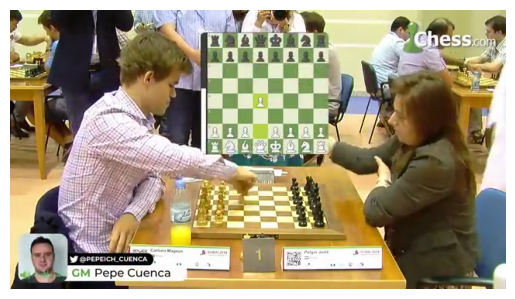

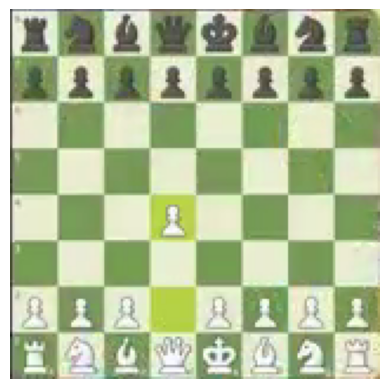

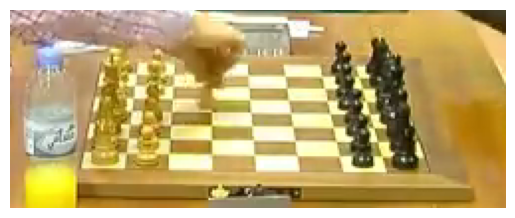

In [29]:
# Extract frame
current_dir = pathlib.Path.cwd()
base_dir = current_dir.parent
video_name = "rrPfmSWlAPM"
video_path = base_dir / "data" / "videos" / f"{video_name}.mp4"

video_min = 0
video_seconds = 3
time_sec =  video_min * 60 + video_seconds
image = get_frame(video_path, time_sec)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis("off")
plt.show()

# Extract ground truth and IRL board
gt_board_loc = [29, 186, 254, 411] # [y1, y2, x1, x2]
irl_board_loc = [200, 300, 200, 450] # [y1, y2, x1, x2]

gt_board, irl_board = extract_gt_board(image, gt_board_loc, irl_board_loc) 

plt.imshow(gt_board)
plt.axis("off")
plt.show()

plt.imshow(irl_board)
plt.axis("off")
plt.show()



### Generate dataset

In [79]:
current_dir = pathlib.Path.cwd()
base_dir = current_dir.parent

# Load id2label map
DATASET_FOLDER_NAME = "chessboard_2d_rendered_aug"
base_dir = pathlib.Path.cwd().parent
dataset_dir = base_dir / "data" / DATASET_FOLDER_NAME
id2label_map = load_id2label_map(dataset_dir)

# Instance predictor
mlruns_dir = str(base_dir / "data" / "mlruns")
run_id = "36aa38a2ba8a41a5841265e48c030eea"
gt_predictor = GTChessboardPredictor(id2label_map, mlruns_dir=mlruns_dir, run_id=run_id)

In [80]:
dataset_id = 1

video_name = datasets_info[dataset_id]["video_id"]
video_path = base_dir / "data" / "videos" / f"{video_name}.mp4"

gt_board_loc = datasets_info[dataset_id]["gt_board_loc"]
irl_board_loc = datasets_info[dataset_id]["irl_board_loc"]

time_range = datasets_info[dataset_id]["time_range"]
step_sec = datasets_info[dataset_id]["step_sec"]

vbe = VideoBoardExtractor(
        video_path=str(video_path),
        gt_board_loc=gt_board_loc,
        irl_board_loc=irl_board_loc,
        time_range=time_range,
        step_sec=step_sec,
        predict_fen=True,
        store_masks=True,
        store_gt_boards=True,
        store_gt_video=True,
        store_irl_boards=True,
        store_irl_video=False,
        store_pred_boards=True,
        store_pred_video=True,
        save_img_freq=True,
        at_first_gt_frame=True,
        purge_output_dir=True,
        store_dir="../data/processed",
        gt_board_predictor=gt_predictor
    )

vbe.process_video()

2025-08-22 22:56:10.297 | INFO     | __main__:make_dirs:315 - Making storage directories
2025-08-22 22:56:10.300 | INFO     | __main__:__init__:150 - Created video extractor for /Users/alexquiroga/Storage/Github/DEEP_LEARNING/COMPUTER_VISION/chess-vision/chess-main/data/videos/rrPfmSWlAPM.mp4
2025-08-22 22:56:10.300 | INFO     | __main__:__init__:151 - IRL Board Location: [200, 300, 200, 450]
2025-08-22 22:56:10.301 | INFO     | __main__:__init__:152 - GT Board Location: [29, 186, 254, 411]
2025-08-22 22:56:10.303 | INFO     | __main__:process_video:190 - Proccessing video capture
2025-08-22 22:56:10.303 | INFO     | __main__:load_videocap:155 - Loading video capture


Extracting frames from 0:02:30 to 6:52:00 ....


410it [04:46,  1.43it/s]                         
OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


# Other tests: Process results

In [59]:
def get_uci(board1, board2, who_moved):
    """
    Get the UCI (Universal Chess Interface) move from the difference between two FEN strings.
    Reference: https://stackoverflow.com/questions/66770587/how-do-i-get-the-played-move-by-comparing-two-different-fens
    """
    nums = {1: "a", 2: "b", 3: "c", 4: "d", 5: "e", 6: "f", 7: "g", 8: "h"}

    str_board = str(board1).split("\n")
    str_board2 = str(board2).split("\n")
    move = ""
    flip = False
    if who_moved == "w":
        for i in range(8)[::-1]:
            for x in range(15)[::-1]:
                if str_board[i][x] != str_board2[i][x]:
                    if str_board[i][x] == "." and move == "":
                        flip = True
                    move += str(nums.get(round(x / 2) + 1)) + str(9 - (i + 1))
    else:
        for i in range(8):
            for x in range(15):
                if str_board[i][x] != str_board2[i][x]:
                    if str_board[i][x] == "." and move == "":
                        flip = True
                    move += str(nums.get(round(x / 2) + 1)) + str(9 - (i + 1))
    if flip:
        move = move[2] + move[3] + move[0] + move[1]

    # Castling
    if move == "h1g1f1e1":
        move = "e1g1"
    elif move == "e8f8g8h8":
        move = "e8g8"
    elif move == "e1d1c1a1":
        move = "e1c1"
    elif move == "e8d8c8a8":
        move = "e8c8"

    return move


def get_fen_df(vbe, min_frames=5):
    """
    Get a DataFrame of FEN strings from the VideoBoardExtractor.

    Args:
        vbe (VideoBoardExtractor): The video board extractor object.
        min_frames (int, optional): The minimum number of frames a FEN must appear in to be included.

    Returns:
        pd.DataFrame: A DataFrame containing the FEN strings and their corresponding frame numbers.
    """

    fen_df = pd.DataFrame(vbe.fens.items(), columns=["frame", "fen"])

    fen_df["frame_count"] = fen_df["fen"].map(fen_df["fen"].value_counts().to_dict())
    fen_df = (
        fen_df.query("frame_count >= @min_frames")
        .drop_duplicates(subset=["fen"])
        .reset_index(drop=True)
        .copy()
    )
    return fen_df

def flip_fen(fen):
    """
    Flip the fen if black is on the top of the board.
    """
    fields = fen.split(" ")
    fields[0] = fields[0][::-1]
    flipped_fen = " ".join(fields)
    return flipped_fen


def fens_to_board(fen_df):
    # Determine if white or black is on top
    top_left_piece = fen_df["fen"].str[0].values[0]
    if top_left_piece == "R":
        # Black is on top so flip all the FENs
        fen_df["fen"] = fen_df["fen"].apply(flip_fen)
    last_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR"
    fen_df["confirmed_move"] = False
    board = chess.Board(last_fen)
    board.set_castling_fen("KQkq")
    move_count = 0
    for i, d in fen_df.iterrows():
        fen = d["fen"]
        frame = d["frame"]
        if last_fen == fen:
            continue
        new_board = chess.Board(fen)
        if move_count % 2 == 0:
            who_moved = "w"
            not_moved = "b"
        else:
            who_moved = "b"
            not_moved = "w"

        move = get_uci(board, new_board, who_moved)
        try:
            # if True:
            board.push_san(move)
            last_fen = fen
            move_count += 1
        except Exception as e:
            try:
                move = get_uci(board, new_board, not_moved)
                board.push_san(move)
                last_fen = fen
                move_count += 1
            except Exception as e:
                print(f"failed move {move_count} with exception {e} frame {frame}")
                print(f"Board before:\n{board}")
                print(f"Board next:\n{new_board}")
                print(f"Mode {move}")
                return fen_df, board
        fen_df.loc[i, "confirmed_move"] = True
        fen_df.loc[i, "move_uci"] = move
    return fen_df, board

In [61]:
fen_df = get_fen_df(vbe, 3)
#fen_df.to_csv(f"../data/labels/{video_id}_raw.csv", index=False)

display(fen_df)

fen_df2, board = fens_to_board(fen_df)

display(fen_df2)

,frame,fen,frame_count
0,0,rnbqkbnr/pppppppp/8/8/8/8/1PPPPPPP/RBBQKBNR,6
1,8,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/1PPP1PPP/RBBQKBNR,3
2,13,rnbqkb1r/pppp1ppp/5n2/4p3/4P3/5N2/1PPP1PPP/RBB...,8
3,23,rnbqkb1r/pppp1ppp/8/4N3/4n3/8/1PPP1PPP/RBBQKB1R,18
4,26,rnbqkb1r/rppp1ppp/8/4N3/4n3/8/1PPP1PPP/RBBQKB1R,3
5,44,rnbqkb1r/pppp1ppp/8/4N3/4n3/3P4/1PP2PPP/RBBQKB1R,6
6,50,rnbqkb1r/pppp1ppp/5n2/4N3/8/3P4/1PP2PPP/RBBQKB1R,4
7,54,rnbqkb1r/pppp1ppp/5n2/4N3/3P4/8/1PP2PPP/RBBQKB1R,3


failed move 0 with exception no matching legal move for a2b1q (a2 -> b1) in rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1 frame 0
Board before:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Board next:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. P P P P P P P
R B B Q K B N R
Mode a2b1


,frame,fen,frame_count,confirmed_move
0,0,rnbqkbnr/pppppppp/8/8/8/8/1PPPPPPP/RBBQKBNR,6,False
1,8,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/1PPP1PPP/RBBQKBNR,3,False
2,13,rnbqkb1r/pppp1ppp/5n2/4p3/4P3/5N2/1PPP1PPP/RBB...,8,False
3,23,rnbqkb1r/pppp1ppp/8/4N3/4n3/8/1PPP1PPP/RBBQKB1R,18,False
4,26,rnbqkb1r/rppp1ppp/8/4N3/4n3/8/1PPP1PPP/RBBQKB1R,3,False
5,44,rnbqkb1r/pppp1ppp/8/4N3/4n3/3P4/1PP2PPP/RBBQKB1R,6,False
6,50,rnbqkb1r/pppp1ppp/5n2/4N3/8/3P4/1PP2PPP/RBBQKB1R,4,False
7,54,rnbqkb1r/pppp1ppp/5n2/4N3/3P4/8/1PP2PPP/RBBQKB1R,3,False
